In [1]:
# @-*- coding = utf-8 _*_
# @Time : 2021/4/28 20:35
# @Author : 杨昌军
# @File : textmining.ipynb
# @Software : PyCharm

In [16]:
import sys #导入sys模块，以实现在指定地方结束程序
import pandas as pd
import numpy as np
import jieba
import jieba.posseg as pseg
import jieba.analyse
import re
from collections import Counter  #导入collections模块中的counter动作以进行词频统计。
from gensim.models.word2vec import Word2Vec  #构建词向量模型
from sklearn.cluster import KMeans  #聚类
import matplotlib.pyplot as plt  #数据可视化
from sklearn.manifold import TSNE  #给数据降维

from a_libs.y_folder import get_this_file_parent_folder as get_pf,select_folder_path as slc_pth



In [17]:
def excel_to_list(excel_file,col_name):  #定义一个函数，将excel中的某一列转化为list列表。
    comments_text_dataframe = pd.read_excel(excel_file, converters={
        'id': str,'text':str})  # 读取excel_file所指称的文件，存入dataframe中，并将id列内容转换为字符串格式（此前为数值格式）。此时comments_text_dataframe是个dataframe。
    comments_text_dataframe = comments_text_dataframe.drop_duplicates()  #全部数据去重。
    comments_text_dataframe.index += 1  #让comments_text_dataframe的索引号+1，即原来是从0开始，现在从1开始。
    comment_list = comments_text_dataframe['text'].values.tolist()
    return comment_list,comments_text_dataframe  #返回一个包含指定列数据的列表、一个包含导入的excel全部内容的dataframe、指定列的列名。
def filter_sentence(data_frame,data_list,col_name,filter_word): #定义一个函数，筛选包含指定词语的句子。
    data_filtered_frame = data_frame.loc[data_frame[col_name].str.contains(filter_word, na=False)] #在text列中查找有“生活”字符串的数据。
    data_filtered_frame.index = range(len(data_filtered_frame))
    data_filtered_frame.index += 1
    comment_filtered_list = []
    for screen in data_list:
        screen = str(screen)
        if screen.find(filter_word) != -1:
            comment_filtered_list.append(screen)
    return data_filtered_frame,comment_filtered_list
def save_all_filtered_data_to_excel(data_frame,save_filename):  #定义一个函数，将筛选过的数据存入excel。
    if save_filename == '':
        save_filename = (input("请输入你存储筛选过的数据的Excel文件名，不用输入后缀名“.xlsx”：")).strip()
        print(f"你准备将筛选过的数据存入{save_filename}.xlsx文件中，请选择此文件的保存路径。")
        save_path = slc_pth(get_pf()) #选择保存路径。
    data_frame.to_excel(f'{save_path}\\{save_filename}.xlsx',index=False)
    print(f'\033[5;30;47m…………筛选后的数据已保存至\033[1;46m{save_path}\033[0m下的“{save_filename}.xlsx”中…………\033[0m')
def clean_text(comments_list,regular_expression): #定义一个函数，进行文本清理。
    text_str = ''.join(str(comments_list))  #通过.join方法合并。
    pattern = re.compile(f'{regular_expression}')
    text_str = re.sub(pattern,'',text_str)
    return text_str
def word_segment_and_pos_tagging(new_words, stop_words, text_str):  #定义一个函数，先加载自定义词典，再加载停用词词典，然后对输入的字符串text_str进行分词，最终输出为列表。
    jieba.enable_paddle()  #利用飞桨Paddle深度学习框架，训练序列标注（双向GRU）网络模型实现分词及词性标注。
    jieba.load_userdict(new_words)    #加载自定义词典。
    stopwords = [line.strip() for line in open(stop_words, encoding='UTF-8').readlines()]   #加载停用词词典，并创建一个停用词列表。此时，stopwords是一个列表。
    print("正在利用飞桨paddle模式对文本进行分词和词性标注，需要一定时间，请稍等。")
    seg_and_tagging_all_word_list = pseg.lcut(text_str,use_paddle=True) #分词并标注词性，默认开启飞桨paddle模式下的分词与词性标注功能，因为对比过开与不开的效果，感觉确实开后分词与标注更精确，具体如何还要研究。
    segged_and_tagged_word_pair_list = []  #既包含词又包含词性的列表。
    for tagging_word in seg_and_tagging_all_word_list:
        if tagging_word.word not in stopwords:  #去除停用词，tagging_word.word为取tagging_word这个pair元组里word的值。
            segged_and_tagged_word_pair_list.append(tagging_word)
    segged_word_list = []  #只包含词，不包含词性。
    for seged_and_tagged_word in segged_and_tagged_word_pair_list:
        seged_word = seged_and_tagged_word.word
        segged_word_list.append(seged_word)
    return  segged_and_tagged_word_pair_list,segged_word_list  #segged_and_tagged_word_pair_list是一个既包含词又包含词性的list，segged_word_list仅包含词，不包含词性。
def sort_word_frequency(data):  #此函数用于统计词频并进行排序。返回的是一个排好序的列表。
    word_frequency_dic = dict(Counter(data))  # 用Counter()统计列表word_list中的词频，并转化为字典word_frequency_dic。注意，这里的Counter的首字母必须大写，否则会出错。
    word_frequency_dic_sorted = sorted(word_frequency_dic.items(), key=lambda x: x[1],reverse=True)  # [:100] #这里是先用字典的.items()方法将字典转换为列表，然后用列表的sorted方法对列表中的元素进行排序，后面的都是参数。
    return word_frequency_dic_sorted
def show_the_highest_ranked_word(data): #此函数用于直接显示排序最高的单词，可以不用。
    num = int(input("你想显示前多少个词频最高的单词/词语："))
    for i in range(num):
        word, count = sort_word_frequency(data)[i]
        print("{0:<10}{1:>5}".format(word, count))  #{0:<10}{1:>5}指定变量值的输出格式，其含义为输出第一个（0）变量时，左对齐（<），最小宽度为10，第二个（1）右对齐（>），最小宽度为5。
def line_word_cut(data_list,new_words,stop_words,re_expression):
    #jieba.enable_paddle()  #开启飞桨深度学习模式。
    #print("正在利用飞桨paddle模式对单条文本进行分词，需要一定时间，请稍等。")
    jieba.load_userdict(new_words)    #加载自定义词典。
    stopwords = [line.strip() for line in open(stop_words, encoding='UTF-8').readlines()]
    line_word_cut_list = []
    line_word_cut_list_have_flag = []
    for line in data_list:
        pattern = re.compile(f'{re_expression}')
        text_str = re.sub(pattern,'',line)
        line = pseg.cut(text_str,use_paddle=False) #如需开启飞桨深度学习模式，请将这里的use_paddle=设为True。
        word_list = []
        word_list_have_flag = []
        for word_pair in line:  #line为分好词的每一条评论。
            if word_pair.word not in stopwords:
                word_list.append(word_pair.word)
                word_list_have_flag.append(word_pair)
        line_word_cut_list.append(word_list)
        line_word_cut_list_have_flag.append(word_list_have_flag)
    return line_word_cut_list,line_word_cut_list_have_flag

In [18]:
excel_file = 'E:\\PycharmProjects\\Demo0410\\work_data_liziqi\\liziqi_total_comments.xlsx' #可以直接填写要处理的excel文件的绝对路径。
col_name = 'text'  #可以直接填写此excel文件中要处理的数据所在的列名。
filter_word = '生活'  #筛选词
new_words = 'E:\\PycharmProjects\\Demo0410\\work_data_liziqi\\new_words.txt'    #自定义词典。
stop_words = 'E:\\PycharmProjects\\Demo0410\\work_data_liziqi\\stop_words.txt'    #停用词词典。
stop_words_after_filtered = 'E:\\PycharmProjects\\Demo0410\\work_data_liziqi\\stop_words_after_filtered.txt'  #相当于上面的停用词词典，主要是加了“生活”一词。
re_expression = '\n|\[.{1,8}\]|[^\u4e00-\u9fa5]'

In [19]:
comment_list, comment_dataframe = excel_to_list(excel_file, col_name)  #调用一开始定义的excel_to_list函数。注意，此函数会返回两个值，一个是包含导入的excel指定列数据的列表，一个是包含导入的excel全部数据的dataframe。
comment_filtered_dataframe,comment_filtered_list = filter_sentence(comment_dataframe,comment_list,col_name,filter_word)

In [20]:
cluster_dataframe = comment_filtered_dataframe.copy(deep=True)  #复制一个新表以备聚类，避免将原表打乱。 = list[cluster_dataframe['text']]
line_word_cut_list, line_word_cut_list_have_flag = line_word_cut(comment_filtered_list,new_words,stop_words,re_expression)  #将每一条评论进行分词，输出的是list of list。
cluster_dataframe['cut'] = line_word_cut_list #将分割好的词重新加入dataframe中。
cluster_dataframe.drop(['id','name','count','time'],axis=1,inplace=True)  #删去新表中多余的列。

In [21]:
jieba.analyse.set_idf_path('idf.txt.big')
tf_idf_list = []
for comment_text in line_word_cut_list:
    comment_text = ''.join(comment_text)
    tf_idf_word = jieba.analyse.extract_tags(
    comment_text,topK=3,allowPOS=('ns','nr', 'n', 'nt','nw','nz','vn', 'vd','v','a','ad','an','d','t')
    )#抽取关键词，topK为抽取的关键词数量为3，参数allowPOS=为仅包括指定词性的词，这里主要是包括各种名词、动词、形容词、副词(d)、时间词（t）,数词（m）,量词（q）。
    tf_idf_list.append(tf_idf_word) #将抽取的关键词加入总列表中。
cluster_dataframe['keywords'] = tf_idf_list #将包含各条评论的关键词重新加入表格中。

In [47]:

#2021年5月3日 0:34分保存的模型较完美，可以不用训练，直接加载使用。但不重新训练会出现模型中的词与此次分词不一样的情况，以致后面出现错误。
n_dim = 100  #word2vec词向量的维度。经试验100维最合适。
model = Word2Vec(vector_size=n_dim, window=5, workers=10, min_count=1)  #创建向量模型实例。经实验window=5最合适。
model.build_vocab(cluster_dataframe.cut)  #生成词表，注意这里的comment_filtered_dataframe.cut必须为list of list，否则会出错。
%time model.train(cluster_dataframe.cut,total_examples=model.corpus_count,epochs=10)  #在评论集上建模。经试验，迭代10次是效果是最好的。
#model.save('liziqi_comment.mod') #保存模型。2021年5月3日 0:34分保存的模型较完美，下次可以不用训练，直接用。
#model = Word2Vec.load('liziqi_comment.mod') #加载此前训练好的模型。

Wall time: 203 ms


(273053, 318130)

In [48]:
model.wv.most_similar('美好')

[('视频', 0.9998172521591187),
 ('自然', 0.9998037815093994),
 ('城市', 0.9997995495796204),
 ('中国', 0.9997969269752502),
 ('人生', 0.9997969269752502),
 ('需要', 0.9997865557670593),
 ('精致', 0.9997847676277161),
 ('感觉', 0.9997799396514893),
 ('其实', 0.9997791051864624),
 ('不是', 0.9997772574424744)]

In [49]:
sentences_vec = [] #关键词加权后所有单条评论的平均向量。
i = 0
active = 0
while active < len(line_word_cut_list):
    line = line_word_cut_list[i]
    keyword_line = tf_idf_list[i]
    sentence_vec = []
    for word in line:
        if word not in keyword_line:
            sentence_vec.append(model.wv[word])
        else:
            keyword_vec = model.wv[word]
            keyword_vec = keyword_vec * 1.1
            sentence_vec.append(keyword_vec)
    sentences_vec.append(sum(sentence_vec)/len(sentence_vec))
    i += 1
    active += 1

#………………以上，目前为止，算法应该没有错……………………

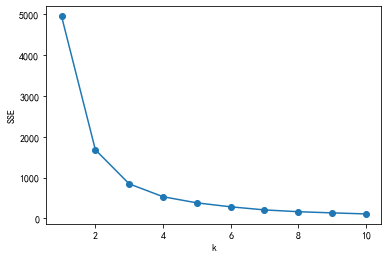

In [50]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,11):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sentences_vec)  #聚类
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,11)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

In [51]:
estimator = KMeans(n_clusters=4) # 构造聚类器，能过上一步骤确定聚类为4簇区分度最明显。
estimator.fit(sentences_vec) #聚类。
label_pred = estimator.labels_ #获取聚类后的簇标签。
cluster_dataframe['cluster'] = label_pred  #将聚类标签添加至表中。
cluster_dataframe.to_excel('聚类.xlsx')  #输出到.xlsx文件。

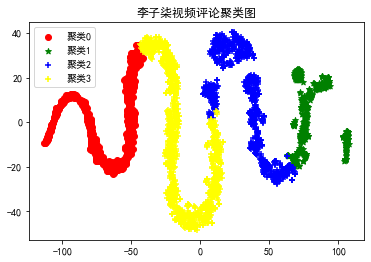

In [52]:
#将原高维数据降为2维。
tsne = TSNE(n_components=2,init='pca',random_state=0)  #给高维数据降维，主要用于数据可视化。
X =  tsne.fit_transform(sentences_vec) #进行数据降维,降成两维

#将降为2维的数据进行可视化。
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置字体为SimHei显示中文。
plt.rcParams['axes.unicode_minus'] = False  #设置正常显示字符。
x0 = X[label_pred == 0]  #提取X列表中所有0聚类的数据。这个还没有搞懂原理，还得再研究。
x1 = X[label_pred == 1]  #提取X列表中所有1聚类的数据。
x2 = X[label_pred == 2]  #提取X列表中所有2聚类的数据。
x3 = X[label_pred == 3]  #提取X列表中所有3聚类的数据。
plt.scatter(x0[:, 0], x0[:, 1], c = "red", marker='o', label='聚类0')
plt.scatter(x1[:, 0], x1[:, 1], c = "green", marker='*', label='聚类1')
plt.scatter(x2[:, 0], x2[:, 1], c = "blue", marker='+', label='聚类2')
plt.scatter(x3[:, 0], x3[:, 1], c = "yellow", marker='+', label='聚类3')
#plt.xlabel('petal length')  #指定x轴的标题为petal length。
#plt.ylabel('petal width')  #指定y轴的标题为petal width。
plt.title('李子柒视频评论聚类图')  #
plt.legend(loc=2)  #指定图例的位置。
#plt.savefig('sin.png')  #保存图片至sin.png。
plt.show()

array([[ 23.76572  ,  30.420792 ],
       [ 31.208208 ,   3.8207536],
       [ 32.092663 ,   6.010046 ],
       ...,
       [ 18.552942 ,  31.494629 ],
       [ 30.202248 ,   4.0799146],
       [ 34.558025 , -14.657158 ]], dtype=float32)

In [ ]:
'''
#1.清理筛选后文本，并进行分词和词性标注。
cleaned_txt = clean_text(comment_filtered_list, re_expression)
segged_and_tagged_word_pair_list,segged_word_list = word_segment_and_pos_tagging(new_words, stop_words_after_filtered, cleaned_txt)
#……………………准备工作，分词和词性标注完成…………………………

#2.对筛选后的语料进行全部评论的主题词提取（去掉“生活”一词，因为就是根据其来筛选的）。
jieba.load_userdict(new_words)  #加载新词词典。
jieba.analyse.set_stop_words(stop_words_after_filtered) #加载停用词典。
tf_idf_comment_filtered_text = ''.join(str(comment_filtered_list))  #将过滤后的语料连接成字符串。
tf_idf_re_expression = '\[.{1,8}\]'  #表示表情包的正则式。
tf_idf_comment_text = clean_text(tf_idf_comment_filtered_text,tf_idf_re_expression)  #去掉表情包里的字符。
jieba.analyse.set_idf_path('idf.txt.big')  #使用从jieba下载的自定义逆向文件频率（IDF）语料库，经验证，关键词提取明显更准确。
tf_idf_word = jieba.analyse.extract_tags(tf_idf_comment_text,topK=20,withWeight=True,allowPOS=('ns','nr', 'n', 'nt','nw','nz','vn', 'vd','v','a','ad','an','d','m','q')) #参数allowPOS=为仅包括指定词性的词，这里主要是包括各种名词、动词、形容词、副词、量词。
#进行主题抽取。
'''


In [ ]:
'''
#原初版本之提取关键词
jieba.load_userdict(new_words)  #加载新词词典。
jieba.analyse.set_stop_words(stop_words_after_filtered)  #抽取关键词时加载停用词词典。
tf_idf_re_expression = '\[.{1,8}\]' #表情包的正则表达式，如[泪目][赞]等。
jieba.analyse.set_idf_path('idf.txt.big')  #使用从jieba下载的自定义逆向文件频率（IDF）语料库，经验证，关键词提取明显更准确。
comment_list = list(cluster_dataframe['text']) #将聚类表cluster_dataframe的text列变为列表。
tf_idf_list = []
for comment_line in comment_list:
    tf_idf_comment_text = clean_text(comment_line,tf_idf_re_expression) #清理文本。
    tf_idf_word = jieba.analyse.extract_tags(
        tf_idf_comment_text,topK=3,allowPOS=('ns','nr', 'n', 'nt','nw','nz','vn', 'vd','v','a','ad','an','d','m','q')
    )  #抽取关键词，topK为抽取的关键词数量为3，参数allowPOS=为仅包括指定词性的词，这里主要是包括各种名词、动词、形容词、副词、量词。
    tf_idf_list.append(tf_idf_word)  #将抽取的关键词加入总列表中。
cluster_dataframe['keywords'] = tf_idf_list #

#原初版本之求每句的平均向量，未乘关键词权重。
sentences_vec = []
for line in line_word_cut_list:
    word_vec = 0
    for word in line:
        word_vec += model.wv[word]
    sentence_vec = word_vec/len(line)
    sentence_vec = sentence_vec.tolist()
    sentences_vec.append(sentence_vec)

#原初版本之求每句的平均向量，乘关键词权重，未乘词性权重。
sentences_vec = [] #关键词加权后所有单条评论的平均向量。
i = 0
active = 0
while active < len(line_word_cut_list):
    line = line_word_cut_list[i]
    keyword_line = tf_idf_list[i]
    sentence_vec = []
    for word in line:
        if word not in keyword_line:
            sentence_vec.append(model.wv[word])
        else:
            keyword_vec = model.wv[word]
            keyword_vec = keyword_vec * 1.1
            sentence_vec.append(keyword_vec)
    sentences_vec.append(sum(sentence_vec)/len(sentence_vec))
    i += 1
    active += 1

#原初版本之求每句的平均向量，乘关键词权重，乘词性权重。经实验证明，乘词性权重后效果并不好，因此弃之不用。
sentences_vec = [] #关键词加权后所有单条评论的平均向量。
i = 0
active = 0
flag_list = ['n','v','a','d']
while active < len(line_word_cut_list_have_flag):
    line = line_word_cut_list_have_flag[i]  #全部单词和词性列表。
    keyword_line = tf_idf_list[i]  #关键词列表。
    sentence_vec = []
    for word in line:
        if word.word not in keyword_line:
            if word.flag in flag_list:
                not_keyword_vec = model.wv[word.word]
                not_keyword_vec = not_keyword_vec * 1.1
            sentence_vec.append(not_keyword_vec)
        else:
            keyword_vec = model.wv[word.word]
            keyword_vec = keyword_vec * 1.1
            if word.flag in flag_list:
                keyword_vec = keyword_vec * 1.1
            sentence_vec.append(keyword_vec)
    sentences_vec.append(sum(sentence_vec)/len(sentence_vec))
    i += 1
    active += 1

#数据可视化之3D版本。
def plot_embedding_3d(X, label,title=None):  #X为降维后的数据，label为聚类后的簇标签。
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1,projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],X[i, 2],str(label[i]),
                 color=plt.cm.Set1(label[i]),  #用plt.cm.set1返回不同的颜色，具体可见：https://blog.csdn.net/qq_41938858/article/details/87705470
                 fontdict={'weight': 'bold', 'size': 9})

    if title is not None:
        plt.title(title)

plot_embedding_3d(X,label_pred)  #运用上面定义的函数。

#数据可视化之2D版本。
def plot_embedding_2d(X, label,title=None):  #X为降维后的数据，label为聚类后的簇标签。
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],str(label[i]),
                 color=plt.cm.Set1(label[i]),  #用plt.cm.set1返回不同的颜色，具体可见：https://blog.csdn.net/qq_41938858/article/details/87705470
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)
    plt.xlabel('petal length') #X轴标题
    plt.ylabel('petal width') #Y轴标题

plot_embedding_2d(X,label_pred)  #运用上面定义的函数。

#散点图绘图
plt.scatter(X[:,0], X[:,1], c = "red", marker='o', label='see') #绘制散点图，X[:,0]代表x轴为X列表中0列中的所有行，X[:,1]代表y轴为X列表中1列中的所有行。
plt.legend(loc = 2) #plt.legend是指定图例（即上行的“label='see'”）的位置，默认为0(右上角)，这里的2是左上角。
plt.show()
'''
def show_cluster_png(data,target,cluster_num):
    plt.rcParams['font.sans-serif'] = ['SimHei']  #设置字体为SimHei显示中文。
    plt.rcParams['axes.unicode_minus'] = False  #设置正常显示字符。
    for i in len(cluster_num):

        x0 = data[target == 0]
        x1 = data[target == 1]
        x2 = data[target == 2]
        x3 = data[target == 3]
        plt.scatter(x0[:, 0], x0[:, 1], c = "red", marker='o', label='聚类0')
        plt.scatter(x1[:, 0], x1[:, 1], c = "green", marker='*', label='聚类1')
        plt.scatter(x2[:, 0], x2[:, 1], c = "blue", marker='+', label='聚类2')
        plt.scatter(x3[:, 0], x3[:, 1], c = "yellow", marker='*', label='聚类3')
    #plt.xlabel('petal length')  #指定x轴的标题为petal length。
    #plt.ylabel('petal width')  #指定y轴的标题为petal width。
    plt.title('李子柒视频评论聚类图')  #
    plt.legend(loc=2)  #指定图例的位置。
    #plt.savefig('sin.png')  #保存图片至sin.png。
    plt.show()